In [1]:
# Script for training a denoiser
import os

os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/gpfslocalsys/cuda/10.1.2'

In [2]:
%load_ext autoreload
%autoreload 2 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from absl import app
from absl import flags
import haiku as hk
import jax
#import optax
import jax.numpy as jnp
import numpy as onp
import pickle
from functools import partial
from jax_lensing.inversion import ks93inv

from flax.metrics import tensorboard

# Import tensorflow for dataset creation and manipulation
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_datasets as tfds

#from jax_lensing.models.convdae import UResNet, SmallUResNet
from jax_lensing.models.normalization import SNParamsTree as CustomSNParamsTree
from jax_lensing.spectral import make_power_map
from jax_lensing.utils import load_dataset
from tqdm.notebook import tqdm

import types
from typing import Mapping, Optional, Sequence, Union

In [4]:
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
from jax_lensing.samplers.score_samplers import ScoreHamiltonianMonteCarlo, ScoreMetropolisAdjustedLangevinAlgorithm
from jax_lensing.samplers.tempered_sampling import TemperedMC

In [5]:
dataset = "kappatng"
#weight_dir = "../weights/gp-no_sn"
weight_dir = "../weights/gp-sn1"
batch_size = 32
gaussian_prior = True
gaussian_path = "../data/ktng/ktng_PS_theory.npy"
map_size = 360
resolution = 0.29
train_split = "90%"
noise_dist_std = 0.2
sigma_gamma = 0.148

In [6]:
rng_seq = hk.PRNGSequence(42)

In [7]:
#import jax
#import jax.numpy as jnp
#import haiku as hk

#import types
from typing import Mapping, Optional, Sequence, Union

def check_length(length, value, name):
  if len(value) != length:
    raise ValueError(f"`{name}` must be of length 4 not {len(value)}")

class BlockV1(hk.Module):
  """ResNet V1 block with optional bottleneck."""

  def __init__(
      self,
      channels: int,
      stride: Union[int, Sequence[int]],
      use_projection: bool,
      bn_config: Mapping[str, float],
      bottleneck: bool,
      transpose: bool = False,
      name: Optional[str] = None
  ):
    super().__init__(name=name)
    self.use_projection = use_projection

    bn_config = dict(bn_config)
    bn_config.setdefault("create_scale", True)
    bn_config.setdefault("create_offset", True)
    bn_config.setdefault("decay_rate", 0.999)

    if transpose:
      maybe_transposed_conv = hk.Conv2DTranspose
    else:
      maybe_transposed_conv = hk.Conv2D

    if self.use_projection:
      self.proj_conv = maybe_transposed_conv(
          output_channels=channels,
          kernel_shape=1,
          stride=stride,
          with_bias=False,
          padding="SAME",
          name="shortcut_conv")

      self.proj_batchnorm = hk.BatchNorm(name="shortcut_batchnorm", **bn_config)

    channel_div = 4 if bottleneck else 1
    conv_0 = hk.Conv2D(
        output_channels=channels // channel_div,
        kernel_shape=1 if bottleneck else 3,
        stride=1,
        with_bias=False,
        padding="SAME",
        name="conv_0")
    bn_0 = hk.BatchNorm(name="batchnorm_0", **bn_config)

    conv_1 = maybe_transposed_conv(
        output_channels=channels // channel_div,
        kernel_shape=3,
        stride=stride,
        with_bias=False,
        padding="SAME",
        name="conv_1")

    bn_1 = hk.BatchNorm(name="batchnorm_1", **bn_config)
    layers = ((conv_0, bn_0), (conv_1, bn_1))

    if bottleneck:
      conv_2 = hk.Conv2D(
          output_channels=channels,
          kernel_shape=1,
          stride=1,
          with_bias=False,
          padding="SAME",
          name="conv_2")

      bn_2 = hk.BatchNorm(name="batchnorm_2", scale_init=jnp.zeros, **bn_config)
      layers = layers + ((conv_2, bn_2),)

    self.layers = layers

  def __call__(self, inputs, is_training, test_local_stats):
    out = shortcut = inputs

    if self.use_projection:
      shortcut = self.proj_conv(shortcut)
      shortcut = self.proj_batchnorm(shortcut, is_training, test_local_stats)

    for i, (conv_i, bn_i) in enumerate(self.layers):
      out = conv_i(out)
      out = bn_i(out, is_training, test_local_stats)
      if i < len(self.layers) - 1:  # Don't apply relu on last layer
        out = jax.nn.relu(out)

    return jax.nn.relu(out + shortcut)

class BlockGroup(hk.Module):
  """Higher level block for ResNet implementation."""

  def __init__(
      self,
      channels: int,
      num_blocks: int,
      stride: Union[int, Sequence[int]],
      bn_config: Mapping[str, float],
      bottleneck: bool,
      use_projection: bool,
      transpose: bool,
      name: Optional[str] = None,
  ):
    super().__init__(name=name)

    block_cls = BlockV1

    self.blocks = []
    for i in range(num_blocks):
      self.blocks.append(
          block_cls(channels=channels,
                    stride=(1 if i else stride),
                    use_projection=(i == 0 and use_projection),
                    bottleneck=bottleneck,
                    bn_config=bn_config,
                    transpose=transpose,
                    name="block_%d" % (i)))

  def __call__(self, inputs, is_training, test_local_stats):
    out = inputs
    for block in self.blocks:
      out = block(out, is_training, test_local_stats)
    return out


class UResNet(hk.Module):
  """ Implementation of a denoising auto-encoder based on a resnet architecture
  """

  def __init__(self,
               blocks_per_group,
               bn_config,
               bottleneck,
               channels_per_group,
               use_projection,
               name=None):
    """Constructs a Residual UNet model based on a traditional ResNet.
    Args:
      blocks_per_group: A sequence of length 4 that indicates the number of
        blocks created in each group.
      bn_config: A dictionary of two elements, ``decay_rate`` and ``eps`` to be
        passed on to the :class:`~haiku.BatchNorm` layers. By default the
        ``decay_rate`` is ``0.9`` and ``eps`` is ``1e-5``.
      resnet_v2: Whether to use the v1 or v2 ResNet implementation. Defaults to
        ``False``.
      bottleneck: Whether the block should bottleneck or not. Defaults to
        ``True``.
      channels_per_group: A sequence of length 4 that indicates the number
        of channels used for each block in each group.
      use_projection: A sequence of length 4 that indicates whether each
        residual block should use projection.
      name: Name of the module.
    """
    super().__init__(name=name)
    self.resnet_v2 = False

    bn_config = dict(bn_config or {})
    bn_config.setdefault("decay_rate", 0.9)
    bn_config.setdefault("eps", 1e-5)
    bn_config.setdefault("create_scale", True)
    bn_config.setdefault("create_offset", True)

    # Number of blocks in each group for ResNet.
    check_length(4, blocks_per_group, "blocks_per_group")
    check_length(4, channels_per_group, "channels_per_group")

    self.initial_conv = hk.Conv2D(
        output_channels=32,
        kernel_shape=7,
        stride=2,
        with_bias=False,
        padding="SAME",
        name="initial_conv")

    if not self.resnet_v2:
      self.initial_batchnorm = hk.BatchNorm(name="initial_batchnorm",
                                            **bn_config)

    self.block_groups = []
    self.up_block_groups = []
    strides = (1, 2, 2, 1)
    for i in range(4):
      self.block_groups.append(
          BlockGroup(channels=channels_per_group[i],
                     num_blocks=blocks_per_group[i],
                     stride=strides[i],
                     bn_config=bn_config,
                     bottleneck=bottleneck,
                     use_projection=use_projection[i],
                     transpose=False,
                     name="block_group_%d" % (i)))

    for i in range(4):
      self.up_block_groups.append(
          BlockGroup(channels=channels_per_group[i],
                     num_blocks=blocks_per_group[i],
                     stride=strides[i],
                     bn_config=bn_config,
                     bottleneck=bottleneck,
                     use_projection=use_projection[i],
                     transpose=True,
                     name="up_block_group_%d" % (i)))

    if self.resnet_v2:
      self.final_batchnorm = hk.BatchNorm(name="final_batchnorm", **bn_config)

    self.final_upconv = hk.Conv2DTranspose(output_channels=1,
                                kernel_shape=5,
                                stride=2,
                                padding="SAME",
                                name="final_upconv")

    self.final_conv = hk.Conv2DTranspose(output_channels=1,
                                kernel_shape=5,
                                stride=2,
                                padding="SAME",
                                name="final_conv")

  def __call__(self, inputs, condition, is_training, test_local_stats=False):
    out = inputs
    out = jnp.concatenate([out, condition*jnp.ones_like(out)[...,[0]]], axis=-1)
    out = self.initial_conv(out)

    # Decreasing resolution
    levels = []
    for block_group in self.block_groups:
      levels.append(out)
      out = block_group(out, is_training, test_local_stats)

    out = jnp.concatenate([out, condition*jnp.ones_like(out)],axis=-1)

    # Increasing resolution
    for i, block_group in enumerate(self.up_block_groups[::-1]):
      out = block_group(out, is_training, test_local_stats)
      out = jnp.concatenate([out, levels[-i-1]],axis=-1)

    # Second to last upsampling, merging with input branch
    return self.final_conv(out)/(jnp.abs(condition)*jnp.ones_like(inputs)+1e-3)

class SmallUResNet(UResNet):
  """ResNet18."""

  def __init__(self,
               bn_config: Optional[Mapping[str, float]] = None,
               name: Optional[str] = None):
    """Constructs a ResNet model.
    Args:
      bn_config: A dictionary of two elements, ``decay_rate`` and ``eps`` to be
        passed on to the :class:`~haiku.BatchNorm` layers.
      resnet_v2: Whether to use the v1 or v2 ResNet implementation. Defaults
        to ``False``.
      name: Name of the module.
    """
    super().__init__(blocks_per_group=(2, 2, 2, 2),
                     bn_config=bn_config,
                     bottleneck=False,
                     channels_per_group=(32, 64, 128, 128),
                     use_projection=(True, True, True, True),
                     name=name)

class MediumUResNet(UResNet):
  """ResNet18."""

  def __init__(self,
               bn_config: Optional[Mapping[str, float]] = None,
               name: Optional[str] = None):
    """Constructs a ResNet model.
    Args:
      bn_config: A dictionary of two elements, ``decay_rate`` and ``eps`` to be
        passed on to the :class:`~haiku.BatchNorm` layers.
      resnet_v2: Whether to use the v1 or v2 ResNet implementation. Defaults
        to ``False``.
      name: Name of the module.
    """
    super().__init__(blocks_per_group=(2, 2, 2, 2),
                     bn_config=bn_config,
                     bottleneck=False,
                     channels_per_group=(32, 64, 128, 128),
                     use_projection=(True, True, True, True),
                     name=name)

class MediumUResNet(UResNet):
  """ResNet18."""

  def __init__(self,
               bn_config: Optional[Mapping[str, float]] = None,
               name: Optional[str] = None):
    """Constructs a ResNet model.
    Args:
      bn_config: A dictionary of two elements, ``decay_rate`` and ``eps`` to be
        passed on to the :class:`~haiku.BatchNorm` layers.
      resnet_v2: Whether to use the v1 or v2 ResNet implementation. Defaults
        to ``False``.
      name: Name of the module.
    """
    super().__init__(blocks_per_group=(2, 2, 2, 2),
                     bn_config=bn_config,
                     bottleneck=False,
                     channels_per_group=(32, 64, 128, 128),
                     use_projection=(True, True, True, True),
                     name=name)

def forward(x, s, is_training=False):
    denoiser = MediumUResNet()
    return denoiser(x, s, is_training=is_training)

model = hk.transform_with_state(forward)

#sn_fn = hk.transform_with_state(lambda x: hk.SNParamsTree(ignore_regex='[^?!.]*b$')(x))
#sn_fn = hk.transform_with_state(lambda x: CustomSNParamsTree(ignore_regex='[^?!.]*b$',val=2.)(x))

In [8]:
# import trained model weights
model_name = "model-35000.pckl"
#model_name = "model-final.pckl"

with open(weight_dir+'/'+ model_name, 'rb') as file: 
    params, state, sn_state = pickle.load(file)

In [9]:
def log_gaussian_prior(map_data, sigma, ps_map):
    data_ft = jnp.fft.fft2(map_data) / float(map_size)
    return -0.5*jnp.sum(jnp.real(data_ft*jnp.conj(data_ft)) / (ps_map+sigma[0]**2))

gaussian_prior_score = jax.vmap(jax.grad(log_gaussian_prior), in_axes=[0,0, None])

pixel_size = jnp.pi * resolution / 180. / 60. #rad/pixel
# If the Gaussian prior is used, load the theoretical power spectrum
if gaussian_prior:
    ps_data = onp.load(gaussian_path).astype('float32')
    ell = jnp.array(ps_data[0,:])
    # massivenu: channel 4
    ps_halofit = jnp.array(ps_data[1,:] / pixel_size**2) # normalisation by pixel size
    # convert to pixel units of our simple power spectrum calculator
    kell = ell / (360/3.5/0.5) / float(map_size)
    # Interpolate the Power Spectrum in Fourier Space
    power_map = jnp.array(make_power_map(ps_halofit, map_size, kps=kell))
    
def score_fn(params, state, rng_key, batch, is_training=True):
    if gaussian_prior:
        # If requested, first compute the Gaussian prior
        gaussian_score = gaussian_prior_score(batch['y'][...,0], batch['s'][...,0], power_map)
        gaussian_score = jnp.expand_dims(gaussian_score, axis=-1)
        net_input = jnp.concatenate([batch['y'], jnp.abs(batch['s'])**2 * gaussian_score],axis=-1)
        res, state = model.apply(params, state, rng_key, net_input, batch['s'], is_training=is_training)
    else:
        res, state = model.apply(params, state, rng_key, batch['y'], batch['s'], is_training=is_training)
        gaussian_score = jnp.zeros_like(res)
    return batch, res, gaussian_score

score_fn = partial(score_fn, params, state, next(rng_seq))

In [10]:
train_set = load_dataset(dataset,
                             batch_size,
                             map_size,
                             noise_dist_std,
                             train_split)

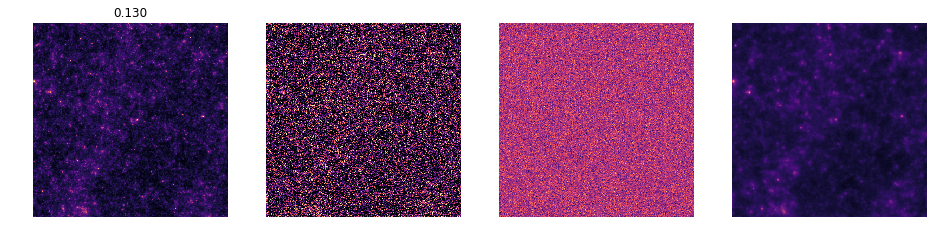

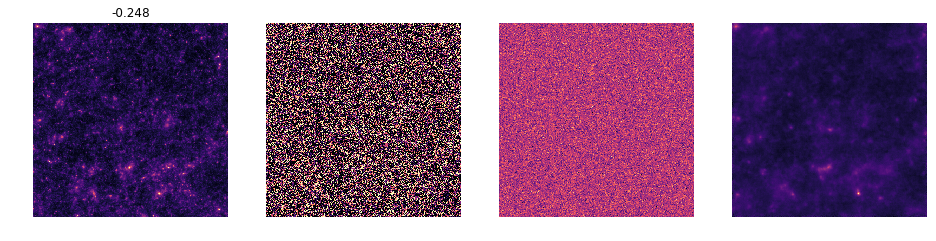

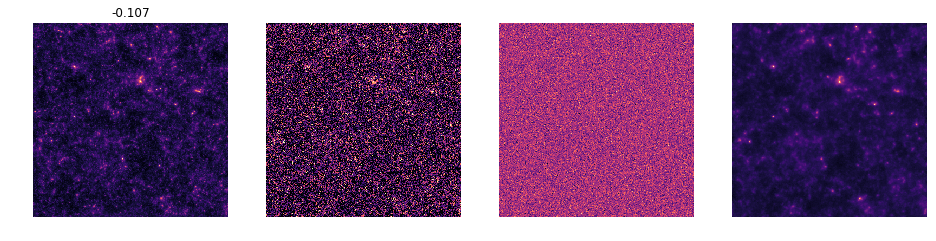

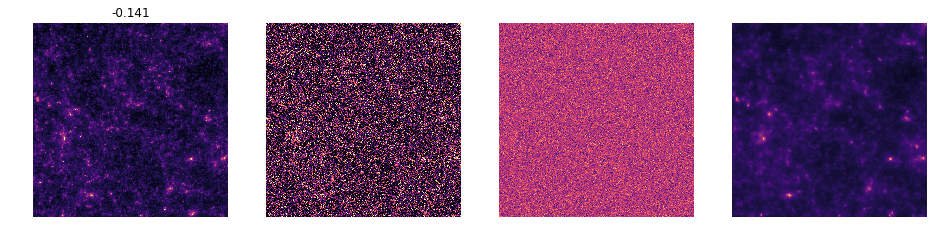

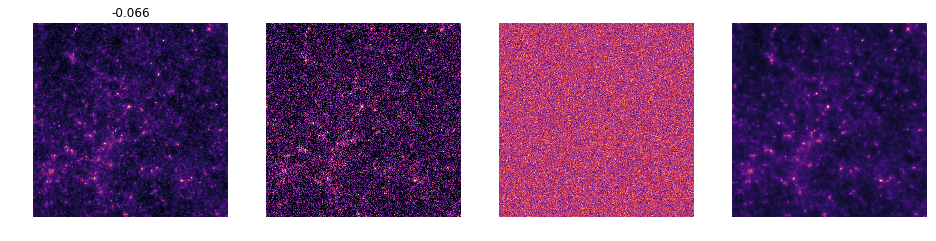

In [11]:
batch = next(train_set)
#res, state = score_fn(batch['x'],batch['s'], is_training=False)
_, res, gaussian_score = score_fn(batch)

for i in range(5):
    ind = i
    figure(figsize=(16,4))
    subplot(141)
    title("%0.3f"%batch['s'][ind,0,0,0])
    imshow(batch['x'][ind,...,0],cmap='magma',vmin=-0.05,vmax=0.3)
    axis('off')
    subplot(142)
    imshow(batch['y'][ind,...,0],cmap='magma',vmin=-0.05,vmax=0.3)
    axis('off')
    subplot(143)
    #imshow(res[ind,...,0],cmap='magma')
    imshow(res[ind,...,0] + gaussian_score[ind,...,0], cmap='magma')
    axis('off')
    #title("%0.3f"%std(batch['s'][ind,:,:,0]**2 * res[ind,...,0]))
    subplot(144)
    #imshow(batch['y'][ind,...,0] + batch['s'][ind,:,:,0]**2 * res[ind,...,0],cmap='magma',vmin=-0.05,vmax=0.3)
    imshow(batch['y'][ind,...,0] + batch['s'][ind,:,:,0]**2 * (res[ind,...,0] + gaussian_score[ind,...,0]),cmap='magma',vmin=-0.05,vmax=0.3)
    #batch['s'] * (res + gaussian_score))**2
    axis('off')

## Annealed sampling

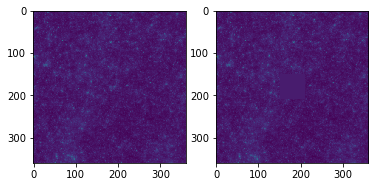

In [12]:
x = batch['x']
mask = np.ones_like(x[0:1])
mask[:, 150:210, 150:210] = 0
x_masked = np.copy(x[0:1]) * mask
subplot(121)
imshow(x[0,...,0])
subplot(122)
imshow(x_masked[0,...,0])

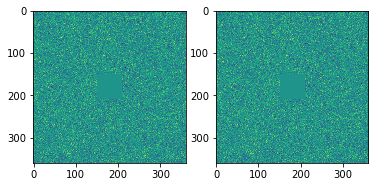

In [13]:
# Shear
mask = mask.reshape((360,360))

kE = x[0,...,0]
kB = jnp.zeros_like(kE)
g1, g2 = ks93inv(kE, kB)
shear_noise = 0.14849374 # per pixel
g1 = g1 + onp.random.randn(map_size, map_size) * shear_noise
g2 = g2 + onp.random.randn(map_size, map_size) * shear_noise

masked_g1 = g1 * mask
masked_g2 = g2 * mask

subplot(121)
imshow(masked_g1)
subplot(122)
imshow(masked_g1)

true_shear = jnp.stack([masked_g1, masked_g2], axis=0).flatten()

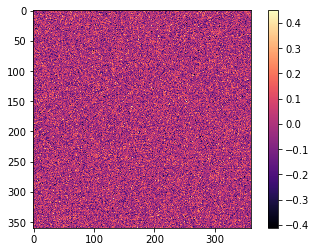

In [14]:
temp = 1e-4
sigma = jnp.ones((1,1)) * temp

init_image=(0.1*randn(1,360,360)).reshape((-1, 360*360)).astype('float32')

imshow(init_image.reshape((360,360)), cmap='magma')
colorbar()

In [15]:
mask2 = jnp.concatenate([mask.flatten(), mask.flatten()])

In [17]:
# likelihood score
def likelihood_fn(x, sigma):
    ke = x.reshape((map_size, map_size))
    kb = jnp.zeros_like(ke)
    gamma1, gamma2 = ks93inv(ke, kb)
    masked_gamma1, masked_gamma2 = (mask.reshape((map_size, map_size))*gamma1,
                                    gamma2*mask.reshape((map_size, map_size)))
    shear = jnp.stack([masked_gamma1, masked_gamma2], axis=0).flatten()
    return jnp.sum( mask2*(shear-true_shear)**2/(sigma_gamma**2 + sigma**2))/2.

score_likelihood = jax.vmap(jax.grad(likelihood_fn))

In [18]:
def score_prior(x, sigma):
    net_input = {'y':x.reshape(1,360, 360,1), 's':sigma.reshape(1,1,1,1)}
    _, res, gaussian_score = score_fn(net_input)
    return (res[..., 0:1] + gaussian_score).reshape(-1, 360*360)

In [19]:
def score_posterior(x, sigma):
    sl = score_likelihood(x, sigma)
    sp = score_prior(x, sigma)
    return (-sl + sp).reshape(-1, 360*360)

DeviceArray([[-1.0780912e+01,  3.1774124e+01, -7.6691360e+00, ...,
               1.7797470e-02, -4.5506639e+00,  2.0555115e+01]],            dtype=float32)

In [20]:
#gamma_init = (jnp.repeat(jnp.expand_dims(mask*gamma,0), 1, axis=0) +
#                jnp.expand_dims((1. - mask)*FLAGS.sigma_gamma,0)*onp.random.randn(FLAGS.batch_size, 320, 320, 2))
#gamma = jnp.stack()
#true_shear.shape

In [21]:
%%time

#sigma_gamma = 0.15
initial_temperature = 0.15
delta_tmp = onp.sqrt(initial_temperature**2 - sigma_gamma**2)
initial_step_size = 0.01
min_steps_per_temp = 10
init_image=(delta_tmp**randn(1,360,360)).reshape((-1, 360*360,)).astype('float32')

def make_kernel_fn(target_log_prob_fn, target_score_fn, sigma):
  return ScoreHamiltonianMonteCarlo(
      target_log_prob_fn=target_log_prob_fn,
      target_score_fn=target_score_fn,
      step_size=initial_step_size*(jnp.max(sigma)/initial_temperature)**0.5,
      #step_size=10*(np.max(sigma)/s0)**0.5,
      num_leapfrog_steps=3,
      num_delta_logp_steps=4)

tmc = TemperedMC(
            target_score_fn=score_posterior,#score_prior,
            inverse_temperatures=initial_temperature*np.ones([1]),
            make_kernel_fn=make_kernel_fn,
            gamma=0.98,
            min_steps_per_temp=min_steps_per_temp,
            num_delta_logp_steps=4)

num_results = int(3e3)
num_burnin_steps = int(0)

samples, trace = tfp.mcmc.sample_chain(
        num_results=num_results,
        current_state=init_image,
        kernel=tmc,
        num_burnin_steps=num_burnin_steps,
        num_steps_between_results=1,
        trace_fn=lambda _, pkr: (pkr.pre_tempering_results.is_accepted,
                                 pkr.post_tempering_inverse_temperatures,
                                 pkr.tempering_log_accept_ratio),
        seed=jax.random.PRNGKey(0))
#######
######

/gpfslocalsup/pub/anaconda-py3/2020.02/envs/tensorflow-gpu-2.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in power
  
/linkhome/rech/genpuc01/utb76xl/.local/lib/python3.7/site-packages/jax/lax/lax.py:6193: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


[Traced<ShapedArray(float32[1,129600]):JaxprTrace(level=1/0)>]
CPU times: user 12min 17s, sys: 1min 39s, total: 13min 56s
Wall time: 13min 46s


Text(0.5,1,'accept tempering')

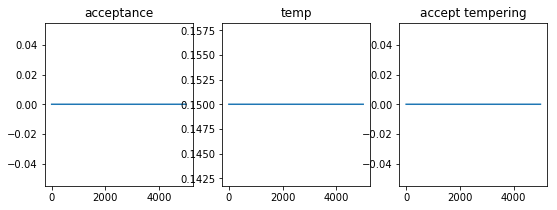

In [22]:
figure(figsize=(9,3))
subplot(131)
plot(trace[0]);
title('acceptance')
subplot(132)
plot(trace[1]);
title('temp')
subplot(133)
plot(exp(trace[2]));
title('accept tempering')

(-0.5, 359.5, 359.5, -0.5)

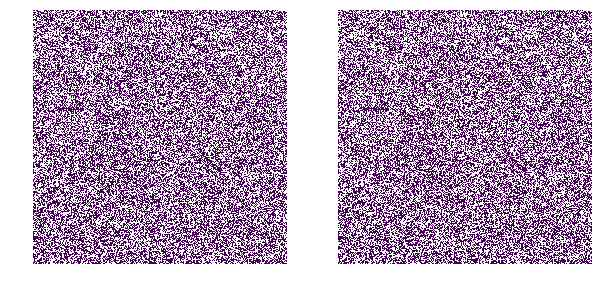

In [23]:
figure(figsize=(10,5))
subplot(121)
imshow(samples[0].reshape((360, 360))); axis('off')
subplot(122)
imshow(samples[-1].reshape((360, 360))); axis('off')

(-0.5, 359.5, 359.5, -0.5)

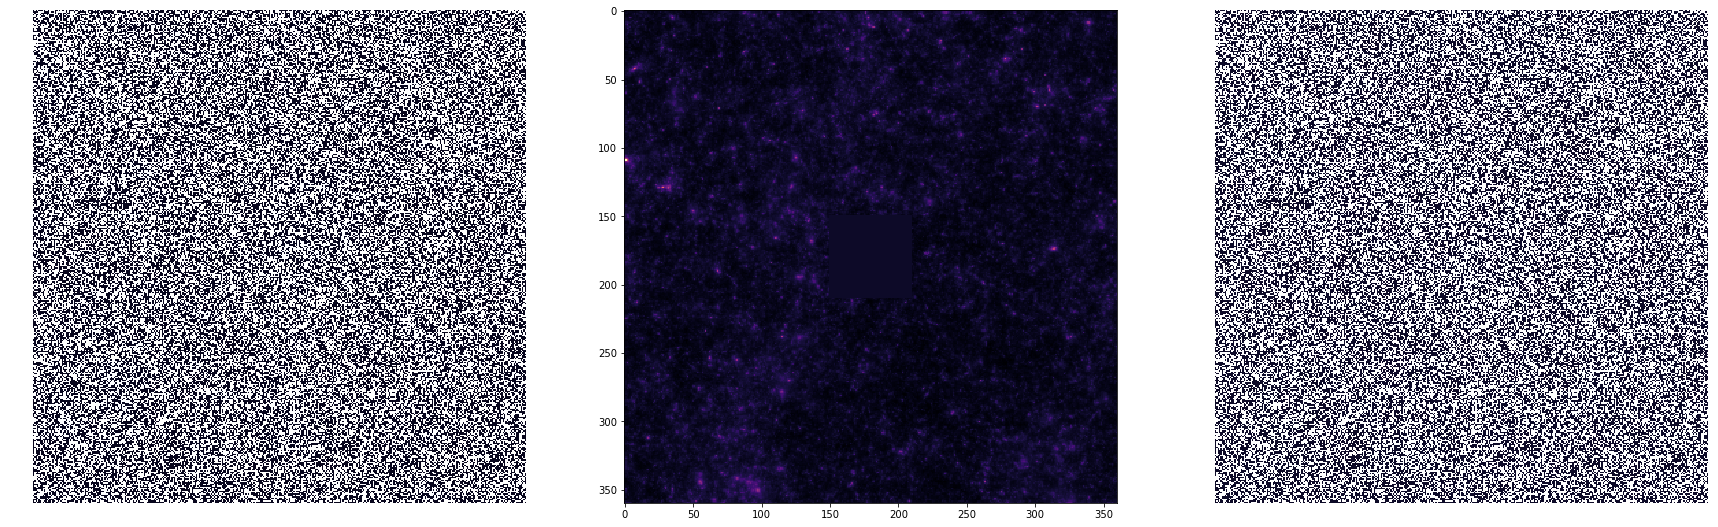

In [24]:
figure(figsize=(30,10))
subplot(131)
imshow(samples[0].reshape((360, 360)),cmap='magma', vmin=batch['x'].min(), vmax=batch['x'].max()); axis('off')
subplot(132)
imshow(x_masked[0,...,0],cmap='magma', vmin=x[0,...,0].min(), vmax=x[0,...,0].max())
subplot(133)
imshow(samples[-1].reshape((360, 360)), cmap='magma', vmin=x[0,...,0].min(), vmax=x[0,...,0].max()); axis('off')

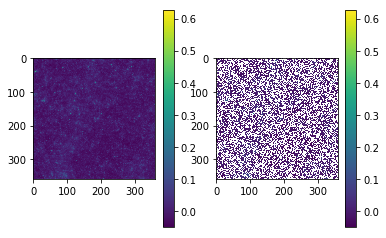

In [25]:
subplot(121)
imshow(x[0,...,0])
colorbar()
subplot(122)
imshow(x[0,...,0] - samples[-1].reshape((360, 360)))
colorbar()